# Using skits library from Ethan Rosental to predict the new Covid Cases

This whole code is based on a [blog post of Ethan Rosental](https://www.ethanrosenthal.com/2018/03/22/time-series-for-scikit-learn-people-part2/). Give it a quick read if you can't follow everything. 

First, we need to install the [skits library](https://github.com/EthanRosenthal/skits) and import necesarry packages from skits and scikit learn. The skits library helps to use scikit learn for time series.

In [22]:
!pip install skits  

In [23]:
from skits.pipeline import ForecasterPipeline, FeatureUnion
from skits.preprocessing import ReversibleImputer, DifferenceTransformer
from sklearn.preprocessing import StandardScaler

In [24]:
from skits.feature_extraction import AutoregressiveTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDRegressor
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              RandomForestRegressor)

Before we start building a time series model, we first need the data to do so. Therefore, we will import the [Covid-19 data from JHU](https://github.com/CSSEGISandData/COVID-19)

In [25]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')

The next step is to import the actual Data from JHU, therfore we defined the function ***fetch_data_jhu***

In [26]:
source_recoverd = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
source_infected = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
source_dead = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

In [27]:
def fetch_data_jhu(link):
    data = pd.read_csv(link)
    # for countries like australia or canada, wher JHU only provides numbers on regional level
    data = data.groupby(['Country/Region']).sum().reset_index()
    # drop unneccessary cols 
    data = data.drop(["Lat","Long"], axis=1)
    return data

Loading the data using the function ***fetch_data_jhu***

In [28]:
infected = fetch_data_jhu(source_infected)
recovered = fetch_data_jhu(source_recoverd)
dead = fetch_data_jhu(source_dead)
# list of all countries
list_of_countries = infected["Country/Region"].values


Creating a dictionary for time series' of infected, dead and recovered. The countrynames are the keys

In [29]:
def generate_data(raw_data, list_of_countries):
    X_train = []
    y_train = []
    X_test = []
    y_test = []  
    all_country_data = {} #dictionary with time series of total # of cases for each country
    for country in tqdm(list_of_countries): # create a time series for every country
        country_data = raw_data.loc[raw_data["Country/Region"] == country].values[0][2:]
        time_series_country = [] # this is the countiry specific time series
        first_zero = True  # skip the beginning of the time series where every country is only 0 and start at the first casetemp = 0
        for i in range(len(country_data)):
            time_series_country.append(country_data[i]) 
        all_country_data[country] = np.array(time_series_country, dtype=float)[:-4]
    
    return all_country_data

In [30]:
dict_timeseries_inf = generate_data(infected, list_of_countries)
dict_timeseries_dead = generate_data(dead, list_of_countries)

100%|██████████| 188/188 [00:00<00:00, 417.04it/s]


Now I do somethoing I don't understand fully yet. This function builds the order of all the preprocessors, features, and ML-models we will use: 
1.   Just look at the difference of cases instead of absolute values
2.   A reversible imputer after every feature is needed
3.   Autoregressive transformer: 
    *   num_lags...decides how many days to use to predict the next one (columns of X)
    *   pred_stride...amount of days i want to predict(columns of y)
4. A reversible imputer after every feature is needed
5. The regressor we will use





In [31]:
def build_pipeline(regressor=Ridge, numlags = 1, pred_stride=1, fitintercept=False): 
    return ForecasterPipeline([
    ('pre_differencer', DifferenceTransformer(period=1)),
    ('pre_diff_imputer', ReversibleImputer()),
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=numlags, pred_stride=pred_stride)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('regressor', regressor(fit_intercept=fitintercept))
])

The following function will correct the offset error our model as

In [32]:
def correct_offset(forecast_array, measured_cases):

    start_idx = len(measured_cases)
    z = np.polyfit(np.arange(5), measured_cases[start_idx-5:start_idx], 1)
    p = np.poly1d(z)
    jump = p(5) -forecast_array[start_idx]
    forecast_array[start_idx:] += jump
    return forecast_array

In [33]:
def make_country_prediction(country_name, days_to_predict):
    pipeline = build_pipeline(numlags=20, pred_stride=days_to_predict)
    for x in [dict_timeseries_inf, dict_timeseries_dead]:
        y_train = np.array(x[country_name])
        y = np.zeros(len(y_train)+days_to_predict, dtype=float)
        y[:len(y_train)] = y_train
        X = y.copy()[:,np.newaxis]
        Xt = pipeline.fit(X[:-days_to_predict],y_train)
        Xt.predict(X[:-days_to_predict], to_scale=True)
        start_idx = len(y_train)
        y_forecast = Xt.forecast(X, start_idx=start_idx)
        y_forecast = correct_offset(y_forecast, y_train)
    
        plt.plot(y_train, '.')
        plt.plot(y_forecast, '.')
        
    ax = plt.gca()
    ylim = ax.get_ylim()
    plt.plot((start_idx, start_idx), ylim)
    plt.ylim(ylim)
    plt.legend(['Actual infected', 'Forecast infected', 'Actual infected', 'Forecast infected', 'Forecast Start'],
               loc='upper left')
    plt.title(str(days_to_predict) + '-day forecast for ' + country_name)

In [34]:
def get_data_for_plot(country_name, days_to_predict):

    pipeline = build_pipeline(numlags=20, pred_stride=days_to_predict)
    y_forecast = []
    y = []
    for i, x in enumerate([dict_timeseries_inf, dict_timeseries_dead]):
        y_train = np.array(x[country_name])[:-(days_to_predict)]
        y_all = np.zeros(len(x[country_name]), dtype=float)
        y_all[:len(y_train)] = y_train
        X = y_all.copy()[:,np.newaxis]
        Xt = pipeline.fit(X[:-days_to_predict],y_train)
        Xt.predict(X[:-days_to_predict], to_scale=True)
        start_idx = len(y_train)
        y_pred = Xt.forecast(X, start_idx=start_idx)
        
        y_forecast.append(correct_offset(y_pred, y_train))
        y.append(x[country_name])
        
    return country_name, days_to_predict, y[0], y_forecast[0], y[1], y_forecast[1]

import datetime
today = datetime.date.today().isoformat()

def plot_country_prediction(country_name, days_to_predict, ts_inf_actual, ts_inf_pred, ts_dead_actual, ts_dead_pred):
    
    # preparing figure layout: size, axis-labels, colours, title, ...
    today = (datetime.date.today()- datetime.timedelta(days = days_to_predict)).isoformat()
    fig, ax1 = plt.subplots(figsize=(12,4))
    fig.suptitle(str(days_to_predict) + '-day forecast for ' + country_name, fontsize='large')
    ax1.set_xlabel('Days since first case')
    ax1.set_ylabel('Total number of infections', color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Total number of deaths', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # plotting infections
    ax1.plot(ts_inf_actual, '-', color='red')
    ax1.plot(ts_inf_pred, '.', color='maroon', markersize=8)
    # plotting deaths
    ax2.plot(ts_dead_actual, '-', color='blue')
    ax2.plot(ts_dead_pred, '.', color='darkcyan', markersize=8) 
    
    #use the same tick-spacing for both y axis and make deaths-line smaller
    ax2.set_yticks(np.linspace(ax2.get_yticks()[0], int(ax2.get_yticks()[-1]*1.5), len(ax1.get_yticks())))
    # plotting start line
    ylim = ax2.get_ylim()
    start_idx = len(ts_inf_actual) - days_to_predict
    ax2.plot((start_idx, start_idx), ylim, color='black')
    # adding legend, grid and layout type
    fig.legend(['Actual infected', 'Forecast infected', 'Actual dead', 'Forecast dead', 'Forecast Start: ' + today], 
               loc=(0.092,0.55), fontsize='medium')
    fig.tight_layout()
    ax1.grid(True)
    
    plt.savefig(country_name + str(days_to_predict) + '.png')
    plt.show()


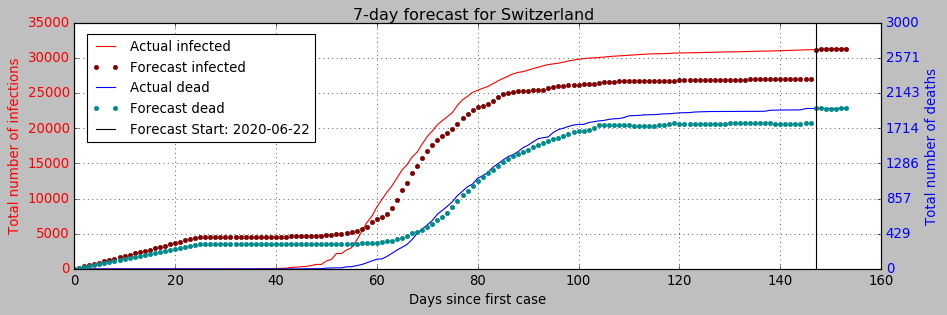

In [35]:
country_name, days_to_predict, inf_actual, inf_pred, dead_actual, dead_pred = get_data_for_plot('Switzerland', 7)
plot_country_prediction(country_name, days_to_predict, inf_actual, inf_pred, dead_actual, dead_pred)

Let's create a function which creates a two-folded dictionary where we add all our predictions. The dictionary will be build as follow:  <br>
predictions = { 'forecast_days' : { 'country_name' : [2_day_forecast, 7_day_forecast, 30_day_forecast] }} <br>
where n_day_forecast = [amount_infected, amount_dead]

In [36]:
def forecast_all_countries(data_infected, data_dead):
    days_to_predict = [2, 7, 30]
    forecast_cases = {} # creating the forecast dictionary
    for days in days_to_predict: 
        forecast_cases[str(days)] = {} # adding the forecast days dictiionary into forecast_cases dictionary
        pipeline = build_pipeline(numlags=20, pred_stride=days) # building the pipeline for our model
        for country in data_infected:      
            """
            the next steps are the following: 
            i)   create the training date for infected and dead, by loading the timeseries of those of one country
            ii)  crate our predicion array: known time series from day 0 to today + zeros for day tomorrow to last forecast day]
            iii) fitting and predicting the training data (day 0 to today)
            iv)  using the trained model to make a forecast
            v)   getting rid of the offset error
            vi)  storing the results in the forecast dictionary
            repeat everything for all countries and different amount of prediction days
            """
            # i)
            y_train_inf = np.array(data_infected[country])[:-(days+1)]
            y_train_dead = np.array(data_dead[country])[:-(days+1)]
            # ii)
            y_inf = np.zeros(len(y_train_inf)+days, dtype=float)
            y_dead = np.zeros(len(y_train_dead)+days, dtype=float)

            y_inf[:len(y_train_inf)] = y_train_inf
            y_dead[:len(y_train_dead)] = y_train_dead
            #iii)
            X_inf = y_inf.copy()[:,np.newaxis]
            X_dead = y_dead.copy()[:,np.newaxis]
            
            Xt_inf = pipeline.fit(X_inf[:-days],y_train_inf)
            Xt_inf.predict(X_inf[:-days], to_scale=True)
            Xt_dead = pipeline.fit(X_dead[:-days],y_train_dead)
            Xt_dead.predict(X_dead[:-days], to_scale=True)
            # iv)
            start_idx = len(y_train_inf)
            
            y_inf = Xt_inf.forecast(X_inf, start_idx=start_idx)
            y_dead = Xt_dead.forecast(X_dead, start_idx=start_idx)
            # v)
            y_inf = correct_offset(y_inf, y_train_inf)
            y_dead = correct_offset(y_dead, y_train_dead)
            
            # vi)
            forecast_cases[str(days)][country] = [y_inf[-1], y_dead[-1]]
    return forecast_cases

Now let's run this model, make predictions and save everything in csv files

In [37]:
forecast = forecast_all_countries(dict_timeseries_inf, dict_timeseries_dead)

In [38]:
import os, csv, datetime

# first, we create a directory to save our predictions
yesterday = datetime.date.today() - datetime.timedelta(days = 1)
path = os.getcwd()
path += '/' + yesterday.isoformat() + '_test'

# let's check if the directory excists already and create it if not
if not os.path.exists(path):
    try:
        os.mkdir(path)
    except OSError:
        print('Creation of the direcotry %s failed' %path)
    else: 
        print('Successfully created the directory %s' %path)
        

# now we can save the forecast results in the newly created folder
for x in forecast: 
    with open(yesterday.isoformat() + '_test'+'/' + x + 'day_prediction_' + yesterday.isoformat() + '.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Province/State','Country', 'Target/Date','N','D', 'N_real', 'D_real'])
        for country in forecast[x]:
            inf_real = dict_timeseries_inf[country][-2]
            dead_real = dict_timeseries_dead[country][-2]
            date = yesterday + datetime.timedelta(days = int(x))
            date = yesterday.isoformat()
            if country == 'Korea, South':
                 writer.writerow(['', 'South Korea', date, int(forecast[x][country][0][0]), int(forecast[x][country][1][0]), inf_real, dead_real])
            else: 
                writer.writerow(['', str(country), date, int(forecast[x][country][0][0]), int(forecast[x][country][1][0]), inf_real, dead_real])

Successfully created the directory C:\Users\Mathias\covid-datathon\src/2020-06-28_test


Additional options to improve the algorithm: Horizon predicitons, different regressor, ...

In [40]:
data2 = np.genfromtxt('2020-06-23_test/2day_prediction_2020-06-23.csv',delimiter=',')
data7 = np.genfromtxt('2020-06-23_test/7day_prediction_2020-06-23.csv',delimiter=',')
data30 = np.genfromtxt('2020-06-23_test/30day_prediction_2020-06-23.csv',delimiter=',')
datas = [data2, data7, data30]
for data in datas:
    error_rel_d = 0
    error_rel_n = 0
    error_ms_d = 0
    error_ms_n = 0
    error_absolute_n = 0
    error_absolute_d = 0
    
    for row in data[1:]:
        error_absolute_n += abs(row[3]-row[5])
        error_absolute_d += abs(row[4]-row[6])
            
        if row[5] == 0: 
            if not row[3] == 0:

                error_rel_n += 1
                error_ms_n += 1
        else:
            error_rel_n += abs(row[3]-row[5])/row[5]
            error_ms_n += ((row[3]-row[5])/row[5]) ** 2

        if row[6] == 0: 
            if not row[4] == 0:
                error_rel_d += 1
                error_ms_d += 1
        else:
            error_rel_d += abs(row[4]-row[6])/row[6]
            error_ms_d += ((row[4]-row[6])/row[6]) ** 2


    error_absolute_d /= (len(data)-1)
    error_absolute_n /= (len(data)-1)
    error_rel_n /= (len(data)-1)
    error_rel_d /= (len(data)-1)
    error_ms_d /= (len(data)-1)
    error_ms_n /= (len(data)-1)

    print("DEAD")
    print("average mse per country = ",error_ms_d)
    print("relative error per country = ", error_rel_d)
    print("absolute error per country = ",error_absolute_d)
    print("INFECTED")
    print("average mse per country = ",error_ms_n)
    print("relative error per country = ", error_rel_n)
    print("absolute error per country = ",error_absolute_n)

DEAD
average mse per country =  0.0077315260945420485
relative error per country =  0.0338197003684265
absolute error per country =  27.79787234042553
INFECTED
average mse per country =  0.00502597363790583
relative error per country =  0.027858516061911403
absolute error per country =  649.5531914893617
DEAD
average mse per country =  0.024046337919579823
relative error per country =  0.07937556735569473
absolute error per country =  81.00531914893617
INFECTED
average mse per country =  0.02383379427103184
relative error per country =  0.08691602609310452
absolute error per country =  1678.781914893617
DEAD
average mse per country =  0.18040493026811613
relative error per country =  0.26488527723419864
absolute error per country =  517.6382978723404
INFECTED
average mse per country =  0.37907640867137526
relative error per country =  0.4052512596085822
absolute error per country =  17519.22340425532


In [ ]:
check_how_good()